In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn

In [4]:
#! pip install h5py nibabel pandas glob2 regex

In [5]:
def runNNLipRemoval2(device, exp, ver, sub):
    sta_epoch = time.time()

    #################################
    ### Lipid Projection Operator ###
    #################################

    s = (64,64,32,960)
    hf = h5py.File('/workspace/walinet/PaulTrainData/'+sub+'/TrainData/'+'TrainData_'+ver+'.h5','r')
    LipidProj_Operator_ff = np.array(hf['lipid_projOP'])
    
    image_rf = np.array(hf['spectra'])
    if image_rf.shape[0]*2>64*64*32:
        image_rf = np.concatenate((image_rf, image_rf), axis=0)
    else:
        image_rf = np.concatenate((image_rf, image_rf, image_rf, image_rf), axis=0)
    image_rrrf = np.reshape(image_rf[:64*64*32], s)

    true_rf = np.array(hf['lipid']) + np.array(hf['water'])
    if true_rf.shape[0]*2>64*64*32:
        true_rf = np.concatenate((true_rf, true_rf), axis=0)
    else:
        true_rf = np.concatenate((true_rf, true_rf, true_rf, true_rf), axis=0)
    true_rrrf = np.reshape(true_rf[:64*64*32], s)

    metab_rrrf = image_rrrf - true_rrrf
    

    ####################
    ### Prepare Data ###
    ####################
    headmask = np.ones((64,64,32))
    skMask = np.ones((64,64,32))
    
    lip = image_rrrf[headmask>0,:]
    lipProj = np.matmul(lip, LipidProj_Operator_ff)
    lip = torch.tensor(lip, dtype=torch.cfloat)
    lipProj = torch.tensor(lipProj, dtype=torch.cfloat)
    true = true_rrrf[headmask>0,:]
    metab_rf = torch.tensor(metab_rrrf[headmask>0,:])

    
    #####################
    ### Prepare Model ###
    #####################


    for f in os.listdir('/workspace/walinet/models/'+exp):
        if f.startswith("src"):
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/')
            sys.path.insert(0, '/workspace/walinet/models/'+exp+'/'+f)
            
            from config import params
            from src.initialize import initialize_model_folder, my_copy
            from src.training import training, validation
            from src.model import yModel
            #from src.model2 import yyModel
            #from src.dataloader import SpecturmSampler, SpectrumDataset
            break

       
    model = yModel(nLayers=params["nLayers"], 
                    nFilters=params["nFilters"], 
                    dropout=0,
                    in_channels=params["in_channels"], 
                    out_channels=params["out_channels"]
                    )
    

    params["path_to_model"] = "/workspace/walinet/models/"+exp+"/"
    model.load_state_dict(torch.load(params["path_to_model"] + 'model_last.pt'))
    #model.load_state_dict(torch.load(params["path_to_model"] + 'model_best.pt'))
    model.to(device)


    #####################
    ### Remove Lipids ###
    #####################

    Data_LipidRemoved_rf, Data_Lipid_rf, loss, spectra_energy  = runModelOnLipData(lip=lip, 
                                                                                lipProj=lipProj, 
                                                                                true=true,
                                                                                metab_rf=metab_rf,
                                                                                model=model,
                                                                                device=device)

    Data_LipidRemoved_rrrf = np.zeros(image_rrrf.shape, dtype=np.cfloat)
    Data_LipidRemoved_rrrf[headmask>0,:] = Data_LipidRemoved_rf.numpy()

    Data_Lipid_rrrf = np.zeros(image_rrrf.shape, dtype=np.cfloat)
    Data_Lipid_rrrf[headmask>0,:] = Data_Lipid_rf.numpy()
    
    loss_rrr = np.zeros((64,64,32), dtype=np.float64)
    loss_rrr[headmask==1] = np.mean(loss.numpy(), axis=(1,2))
    
    lipProj_rrrf = np.zeros(image_rrrf.shape, dtype=np.cfloat)
    lipProj_rrrf[headmask>0,:] = lipProj
    
    spectra_energy_rrr = np.zeros((64,64,32), dtype=np.float64)
    spectra_energy_rrr[headmask==1] = spectra_energy[:,0].numpy()
    

    return Data_LipidRemoved_rrrf, Data_Lipid_rrrf, image_rrrf, lipProj_rrrf, metab_rrrf, true_rrrf, loss_rrr, spectra_energy_rrr


def runModelOnLipData(lip, lipProj, true, metab_rf, model, device):
    
    #spectra_energy = torch.sqrt(torch.sum(torch.abs(metab_rf)**2, dim=1))[:,None]
    #metab_energy = torch.amax(torch.abs(metab_rf), dim=1)[:,None]#
    #metab_energy = torch.sqrt(torch.sum(torch.abs(metab_rf)**2, dim=1))[:,None]
    #spectra_energy = torch.amax(torch.abs(lip), dim=1)[:,None]
    #spectra_energy = torch.sqrt(torch.sum(torch.abs(lip[:,200:320]-lipProj[:,200:320])**2, dim=1))[:,None]
    spectra_energy = torch.sqrt(torch.sum(torch.abs(lip-lipProj)**2, dim=1))[:,None]
    lip /= spectra_energy
    lip = torch.stack((torch.real(lip), torch.imag(lip)), axis=1)
    lipProj /= spectra_energy
    lipProj = torch.stack((torch.real(lipProj), torch.imag(lipProj)), axis=1)
    true /= spectra_energy
    true = torch.stack((torch.real(true), torch.imag(true)), axis=1)

    prediction = torch.zeros(lip.shape, dtype=torch.float64)
    datasz = lipProj.shape[0]
    batchsz = 200
    
    loss_func = nn.MSELoss(reduction='none')
    model.eval()
    with torch.no_grad():
        for i in range(int(datasz/batchsz)+1):
            log = 'Percent: {:.2f}%'
            percent = (i+1)/int(datasz/batchsz)*100
            print(log.format(percent), end='\r')
            lip_batch = lip[i*batchsz:(i+1)*batchsz,:,:]
            lipProj_batch = lipProj[i*batchsz:(i+1)*batchsz,:,:]
            true_batch = true[i*batchsz:(i+1)*batchsz,:,:]
            
            lip_batch, lipProj_batch = lip_batch.to(device), lipProj_batch.to(device)
            pred = model(lip_batch, lipProj_batch)[:,:2,:].cpu()
            prediction[i*batchsz:(i+1)*batchsz,:] = pred
    
    
    
    loss = loss_func(lip, true)
    print('Inp loss: ', torch.mean(loss).item())
    loss = loss_func(prediction, true)
    print('Pred loss: ', torch.mean(loss).item())
    
    prediction = prediction[:,0] + 1j*prediction[:,1]
    prediction = prediction*spectra_energy
    lip = lip[:,0] + 1j*lip[:,1]
    lip = lip * spectra_energy
    Data_LipidRemoved_rf = lip - prediction
    
    return Data_LipidRemoved_rf, prediction, loss, spectra_energy



device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#exp='EXP_1'
#exp='EXP_2'
#exp='EXP_2p3'
#exp='EXP_3'
exp='EXP_3p3'
#exp='test'

#ver = 'v3_2'
ver = 'v4_4'

sub = '3DMRSIMAP_Vol_06_A_1_2024-08-22_L2_0p0005'

Data_LipidRemoved_rrrf, Data_Lipid_rrrf, lip_rrrf, lipProj_rrrf, metab_rrrf, nuisance_rrrf, loss_rrr, spectra_energy_rrr = runNNLipRemoval2(device=device,
                                                                                                                                            exp=exp,
                                                                                                                                            ver=ver,
                                                                                                                                            sub=sub)

Inp loss:  nan5%
Pred loss:  nan


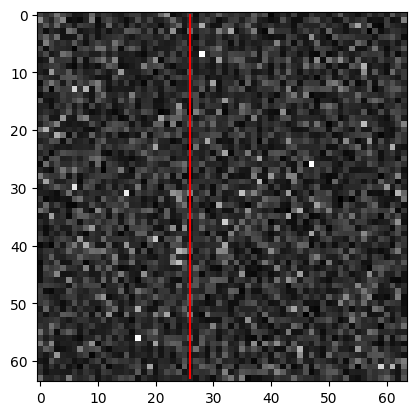

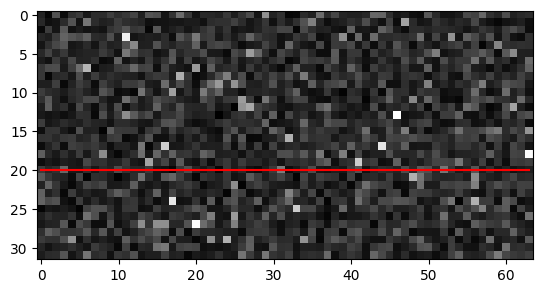

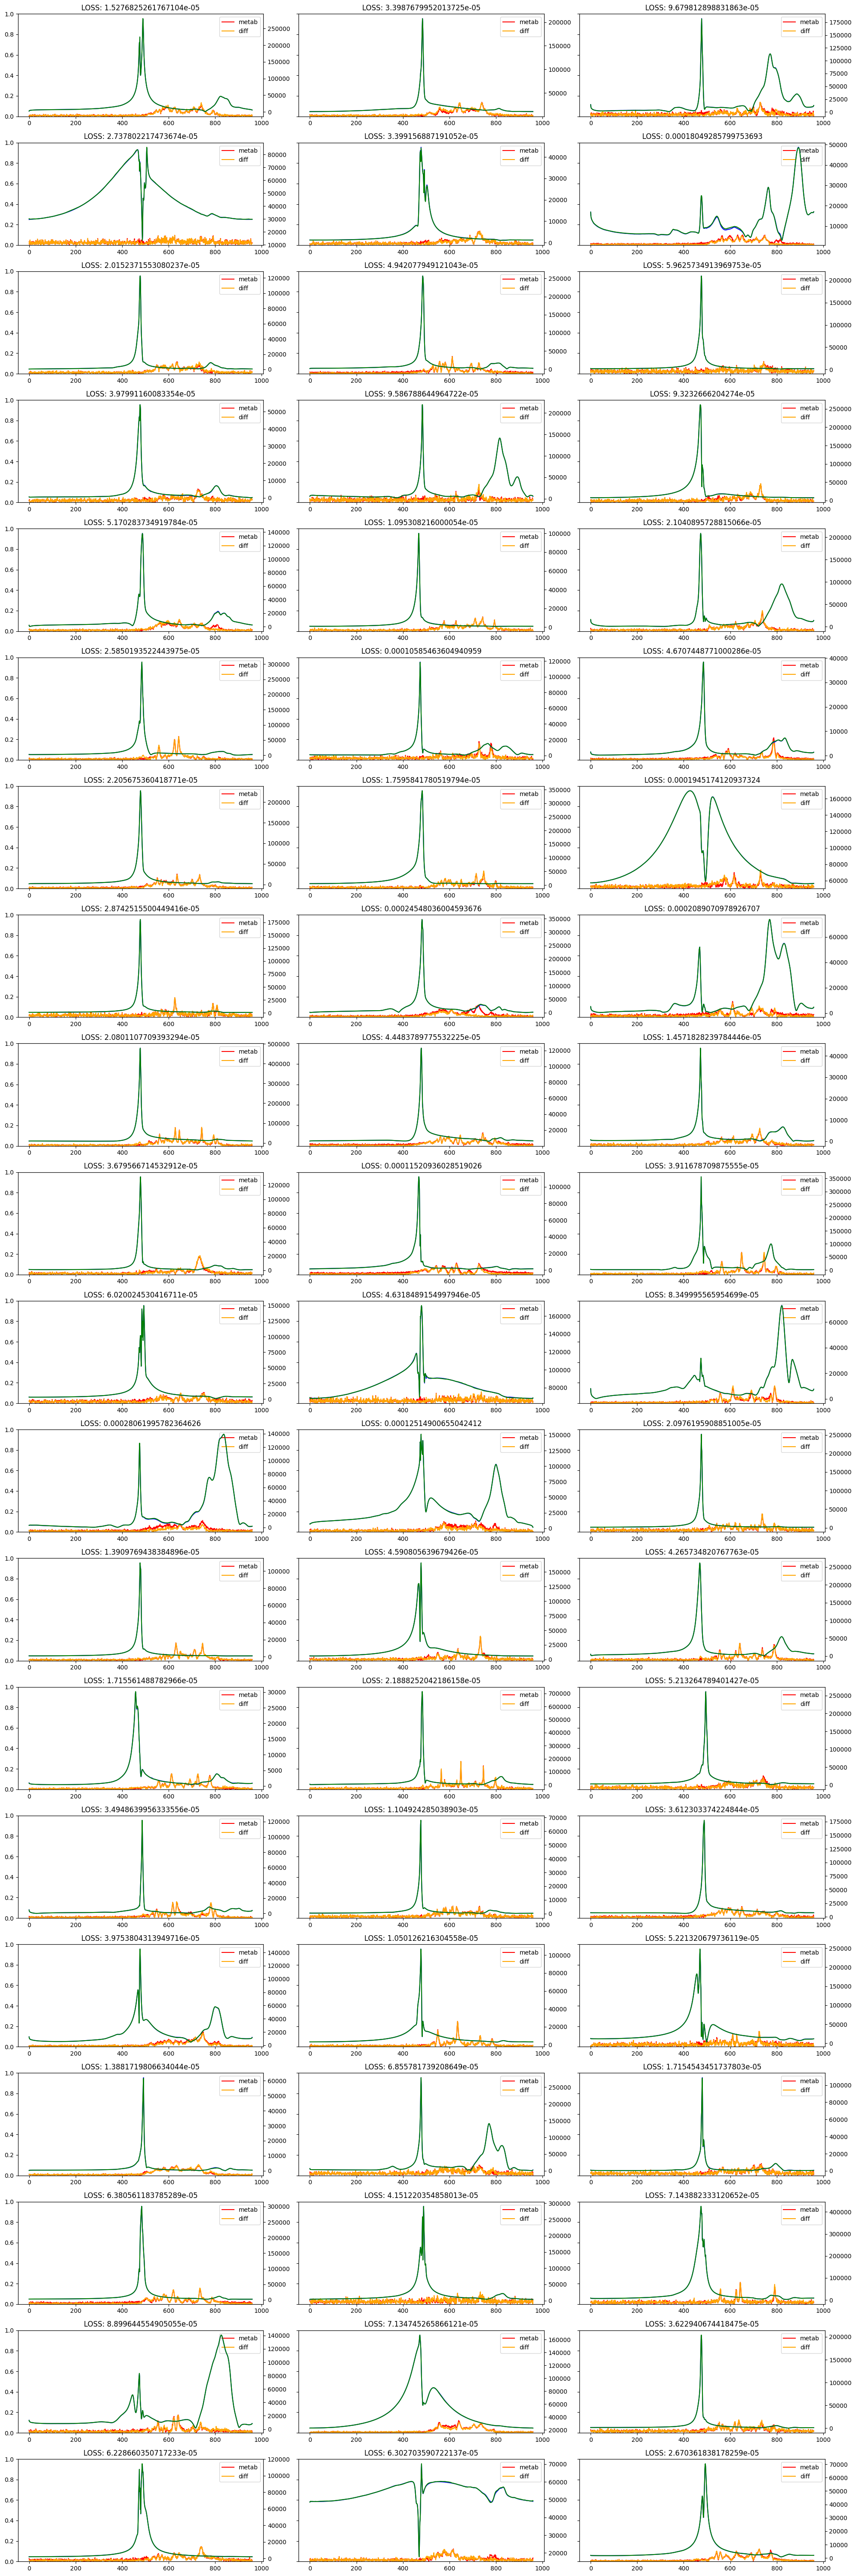

In [6]:
zdim=20
ydim=26

sum_img_grid = np.sum(np.abs(Data_LipidRemoved_rrrf), axis=-1)



plt.imshow(sum_img_grid[:,:,zdim], cmap="gray")
x = [ydim, ydim]
y = [0,63]
plt.plot(x,y,'red')
plt.show()
plt.imshow(np.flip(np.rot90(sum_img_grid[:,ydim,:], k=3), axis=1), cmap="gray")
x = [0,63]
y = [zdim, zdim]
plt.plot(x,y,'red')
plt.show()



fig, ax = plt.subplots(nrows=20, ncols=3, figsize=(20,60), sharey=True)
for i in range(20):
    for ii in range(3):
        sl = i*3 + ii
        metab_energy = np.sqrt(np.sum(np.abs(metab_rrrf[sl,ydim,zdim,:])**2))
        if metab_energy <0.25:
            metab_energy=0.25
        metab_max = np.amax(np.abs(metab_rrrf[sl,ydim,zdim,:]))
        if metab_max <0.001:
            metab_max=0.001
        spectra_energy = spectra_energy_rrr[sl,ydim,zdim]
        norm = metab_energy#/spectra_energy
        
        spec1 = Data_LipidRemoved_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        spec3 = metab_rrrf[sl,ydim,zdim,:]/norm#/spectra_energy_rrr[sl,ydim,zdim]
        ax[i,ii].plot(np.abs(spec3), label='metab', color='red')
        ax[i,ii].plot(np.abs(spec1), label='diff', color='orange')
        ax[i,ii].set_ylim([0,1])
        ax[i,ii].legend()
        
        ax2 = ax[i,ii].twinx()
        
        spec1 = Data_Lipid_rrrf[sl,ydim,zdim,:]
        spec3 = nuisance_rrrf[sl,ydim,zdim,:]
        ax2.plot(np.abs(spec3), label='nuisance', color='blue')
        ax2.plot(np.abs(spec1), label='pred_nuisance', color='green')
        #ax2.set_ylim([0,600])
        #ax2.legend()
        
        
        norm = (metab_energy/spectra_energy)**2
        ax[i,ii].title.set_text('LOSS: ' + str(loss_rrr[sl,ydim,zdim]/norm))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
fig.tight_layout()
#plt.savefig("images/"+exp+'_DS'+ver)
plt.show()